In [746]:
import torch
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import numpy
import pandas
from typing import Optional
from tqdm import tqdm
import torch.utils.data as data_utils
from torch.nn.functional import normalize


# Creating custom dataset from CSV file

In [747]:
class MyDiabetesDataset(torch.utils.data.Dataset):
	def __init__(self, csv_file):
		self.data = pandas.read_csv(csv_file, sep="\t")
	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		#print("Returning sample at index {}".format(index))
		data = self.data.iloc[index]
		#data = data.to_numpy().astype(numpy.float32)
		data = torch.tensor(data, dtype=torch.float32)

		sample = data[0:10]  # other columns are the features to train on
		target = data[10]  # column Y is the target
		
		target = torch.tensor(target, dtype=torch.float32)

		return sample , target

dataset = MyDiabetesDataset("diabetes.csv")
print(dataset[0], type(dataset[0]))
dataloader = DataLoader(dataset)
dataset.data

(tensor([ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
          4.0000,   4.8598,  87.0000]), tensor(151.)) <class 'tuple'>


C:\Users\Shlomi\AppData\Local\Temp/ipykernel_23724/57682996.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.float32)


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


# Creating custom loader for our custom dataset

This allows:
- Batching
- Shuffling the data
- Load the data in parallel using `multiprocess` workers

# Creating model

In [748]:
model = nn.Sequential(
	nn.BatchNorm1d(10), # We use batch normalization because this dataset contains many unique numbers, its hard to train. Normalization sets the values between 0 and 1 so its easier to train.

	nn.Linear(10, 100),
	nn.ReLU(),

	# nn.BatchNorm1d(100),
	nn.Linear(100, 100),
	nn.ReLU(),

	# nn.BatchNorm1d(100),
	nn.Linear(100, 500),
	nn.ReLU(),

	nn.BatchNorm1d(500),
	nn.Linear(500, 1),
	nn.ReLU(),

	# nn.Dropout(0.2),
	# nn.LogSoftmax()
)

# Train

Target is last column (column 11 is measure of diabetes, is a number, not classical linear regression!)

### Set cost function, optimizer function

In [749]:
#loss_func = nn.MSELoss()  # This is a regression problem, not a classification problem! Took me a while to figure this out.
loss_func = nn.HuberLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=300)  # Stochistic Gradient Descent - classic
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.0001)  # Adamax - faster than SGD

### Set batch processing function

# Train

In [750]:
epochs = 20

loss_train=torch.zeros(epochs)
acc_train=torch.zeros(epochs)
loss_test=torch.zeros(epochs)
acc_test=torch.zeros(epochs)

dataset_numpy = dataset.data.to_numpy()
dataset_tensor = torch.tensor(dataset_numpy, dtype=torch.float32)

train_samples_tensors = dataset_tensor[:, 0:10]
train_samples_targets = dataset_tensor[:, 10]

print("Target mean, std: {} {} ".format(train_samples_targets.mean(), train_samples_targets.std()))

train_samples_targets = torch.nn.functional.normalize(train_samples_targets, dim=0)
train_samples_tensors = torch.nn.functional.normalize(train_samples_tensors)

# train_samples_targets -= train_samples_targets.min()
# train_samples_targets /= train_samples_targets.max()

model[0].reset_parameters()

print("Target mean, std: {} {} ".format(train_samples_targets.mean(), train_samples_targets.std()))


for epoch_idx in tqdm(range(epochs)):
	optimizer.zero_grad() # Zero gradient before every batch

	y_model = model(train_samples_tensors)  # Predict the output of the model

	loss = loss_func(y_model, train_samples_targets)  # Calculate loss

	loss.backward()  # Calculate gradients
	optimizer.step()  # Update weights

	good_predict = torch.abs(train_samples_targets - y_model) < (train_samples_targets * 0.1)
	acc = good_predict.sum()


	# acc = torch.abs(train_samples_targets - y_model)

	loss_train[epoch_idx] = loss.item()
	acc_train[epoch_idx] = acc.item()


Target mean, std: 152.13348388671875 77.09300231933594 
Target mean, std: 0.04243827238678932 0.021505415439605713 


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\Shlomi\anaconda3\lib\site-packages\torch\nn\modules\loss.py:972: UserWarning: Using a target size (torch.Size([442])) that is different to the input size (torch.Size([442, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
100%|██████████| 20/20 [00:00<00:00, 123.46it/s]


Text(0.5, 0, 'Epoch Number')

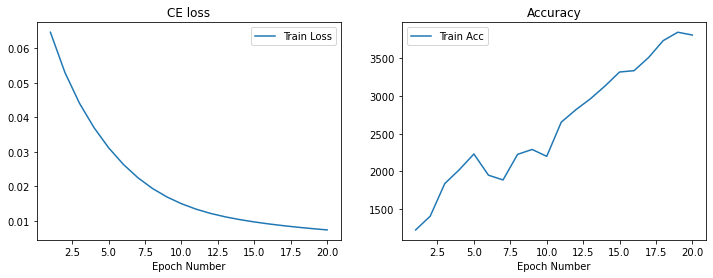

In [751]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1,epochs+1),loss_train,label="Train Loss")
plt.title("CE loss")
plt.legend()
plt.xlabel("Epoch Number")

plt.subplot(1,2,2)
plt.plot(range(1,epochs+1),acc_train,label="Train Acc")
#plt.plot(range(1,epochs+1),acc_test,label="Test Acc")
plt.title("Accuracy")
plt.legend()
plt.xlabel("Epoch Number")